# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

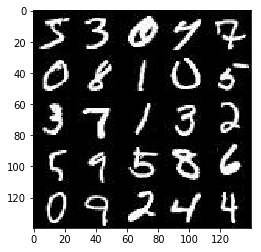

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

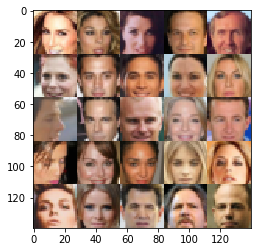

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_shape = (None, image_width, image_height, image_channels)
    real_inputs = tf.placeholder(tf.float32, shape=real_shape, name='real_inputs')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')
    
    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
import numpy as np

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def conv_layer(layer, filters, batch_norm=True):
        kernel_size=5
        strides=2
        weights_initializer = tf.contrib.layers.xavier_initializer()
        #layer = tf.layers.conv2d(layer, filters, kernel_size, strides, padding='same')
        layer = tf.layers.conv2d(layer, filters, kernel_size, strides, activation=tf.nn.relu,kernel_initializer=weights_initializer,padding='same')
        if batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        alpha = 0.2
        layer = tf.maximum(alpha * layer, layer)
        layer = tf.layers.dropout(layer, rate = 0.6)
        return layer
    
    # Flatten it
    def fully_connected(layer):
        shape = np.prod(layer.shape[1:]).value
        flat = tf.reshape(layer, (-1, shape))
        logits = tf.layers.dense(flat, 1)
        return logits
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
        for conv_args in [(56,  True),(112, False),(224, False)]:
            layer = conv_layer(images, *conv_args)   
        logits = fully_connected(layer)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb 
    # First fully connected layer
    def fully_connected_layer(layer):
        flat_sharp = (7, 7, 224)
        layer = tf.layers.dense(z, np.prod(flat_sharp))
        layer = tf.reshape(layer, (-1, *flat_sharp))
        return layer
    
    def conv_transpose_layer(layer, filters,kernel_size,strides):
        alpha = 0.2
        #weights_initializer = tf.contrib.layers.xavier_initializer()
        #kernel_initializer=weights_initializer
        if isinstance(filters, int):
            layer = tf.layers.conv2d_transpose(layer, filters, kernel_size, strides, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        #layer = tf.layers.dropout(layer, rate = 0.6)
        return layer
    
    with tf.variable_scope("generator", reuse = not is_train):
        layer = fully_connected_layer(z)
        layer = conv_transpose_layer(layer,*(None, 0, 0))
        layer = conv_transpose_layer(layer,*(224,  5, 2))
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, strides=2,padding='same')
        
        # Output layer :28 x 28 x out_channel_dim 维度图像
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    smooth = 0.1
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)*(1-smooth)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
      
    disc_loss = dis_loss_real + dis_loss_fake

    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    
    # Get weights and bias to update
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
       
    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    
    print_every = 10
    show_every = 100
    show_count = 25
    
    out_channel_dim  = data_shape[-1]
    real_inputs, z_inputs, _ = model_inputs(*data_shape[1:], z_dim)
    disc_loss, gen_loss = model_loss(real_inputs, z_inputs, out_channel_dim)
    disc_opt, gen_opt  = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    def print_progress():
        train_loss_d = disc_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
        train_loss_g = gen_loss.eval({z_inputs: batch_z})
        print("Epoch {}/{}...".format(epoch_i + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
    def show_progress():
        show_generator_output(sess, show_count, z_inputs, out_channel_dim, data_image_mode)
        
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(disc_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z})
                sess.run(gen_opt,  feed_dict={real_inputs: batch_images, z_inputs: batch_z})

                if step % print_every == 0:
                    print_progress()
                if step % show_every == 0:
                    show_progress()

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.7338


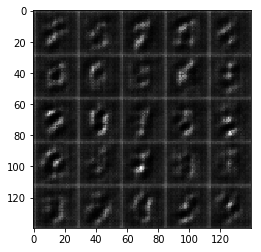

Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7491


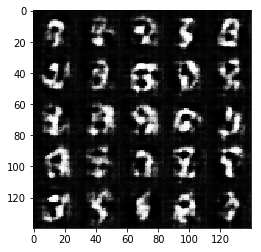

Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7931


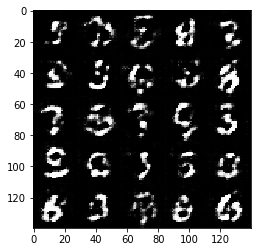

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.8238
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.8089


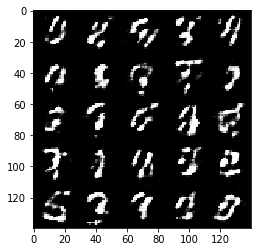

Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.8587


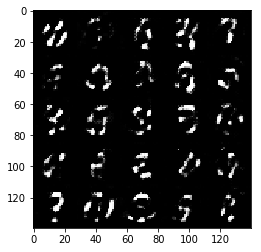

Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.9268


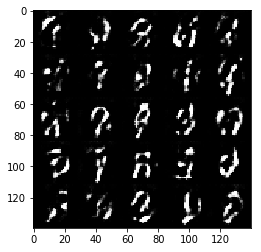

Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.8513


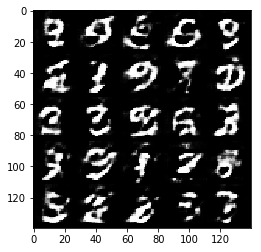

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.8195
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 0.8281


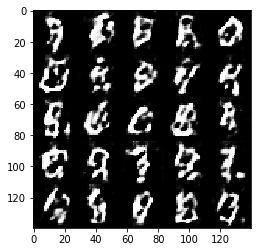

Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.8512


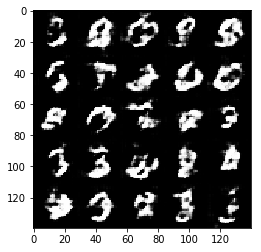

Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.6075... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.8506


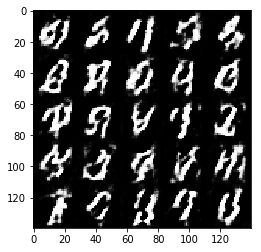

Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.9565


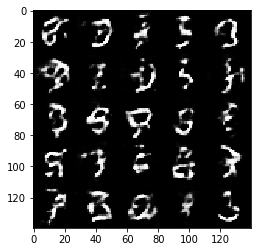

Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.9027


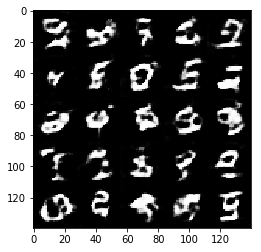

Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.8418
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.8743


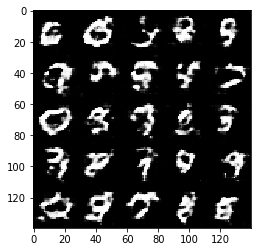

Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.8162


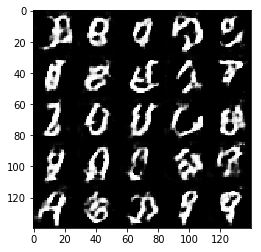

Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8125


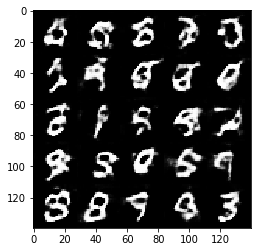

Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.8235


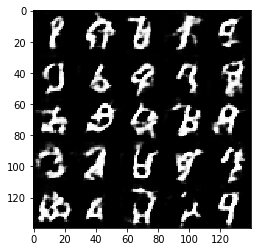

Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.8311


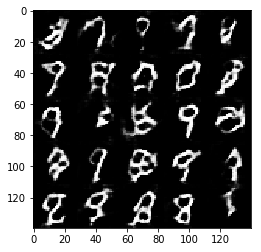

Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.8256
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.7971


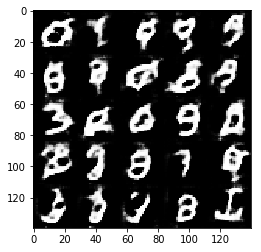

Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.9071


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8720


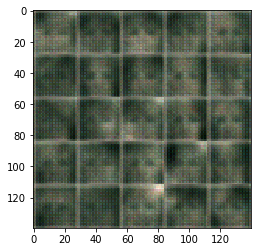

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8022


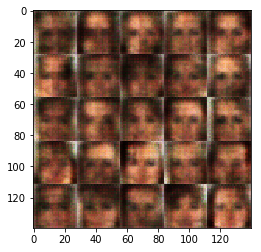

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8535


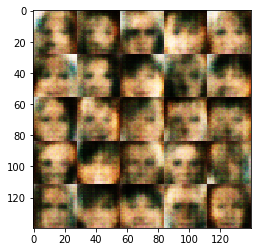

Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9647


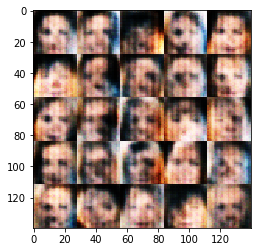

Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.0518


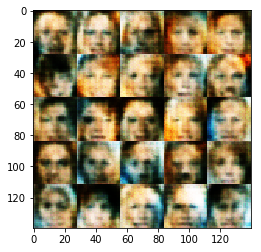

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 2.0183


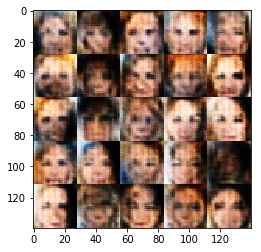

Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.9407
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8790


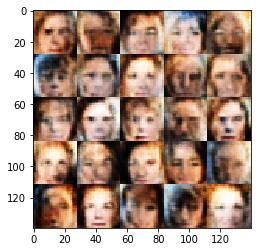

Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.7463


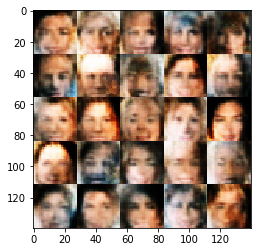

Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.8723
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9322


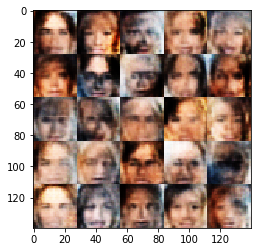

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.3335
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.2316


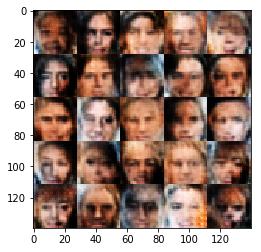

Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.0549


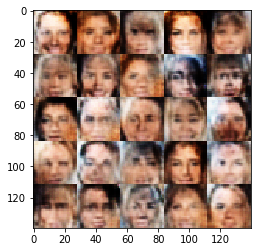

Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8621


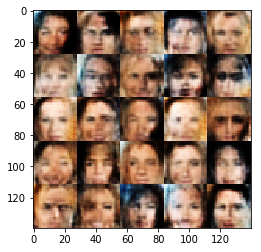

Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.1074


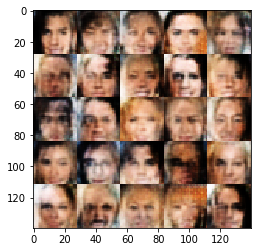

Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.1524


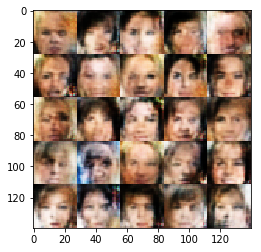

Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.7233


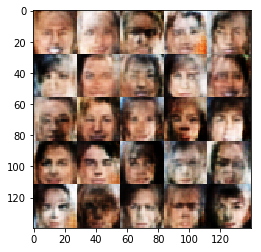

Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.0597


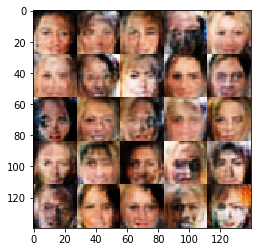

Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.1986


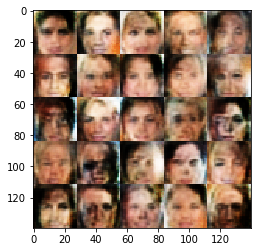

Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9797


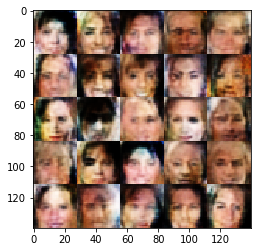

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8329


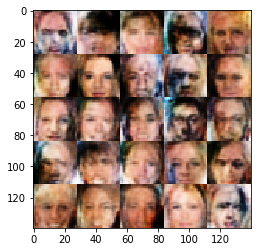

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.0063


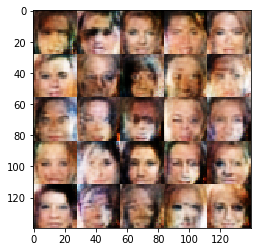

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9736


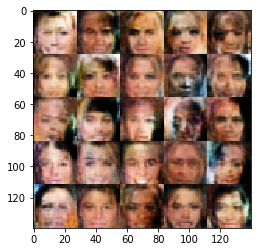

Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8365


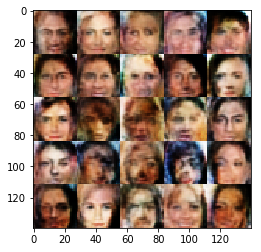

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9578


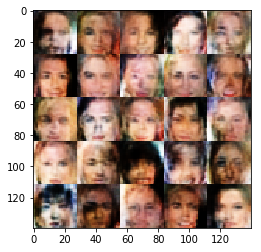

Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8365


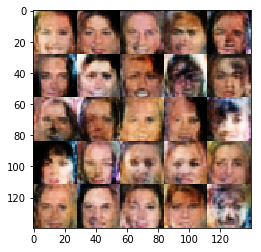

Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9344


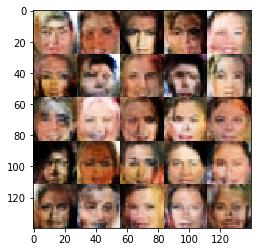

Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.0025


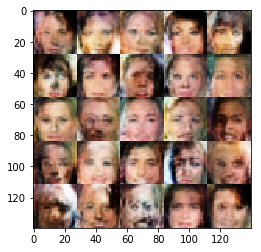

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.1336


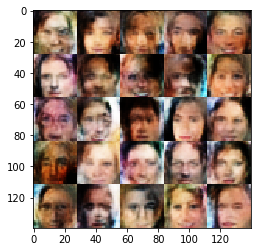

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8018


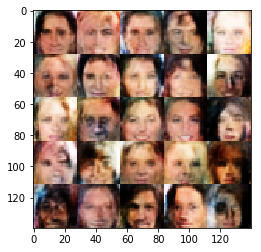

Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8562


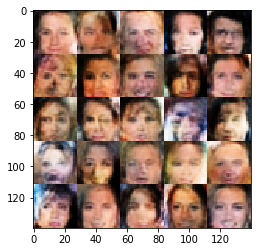

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6787


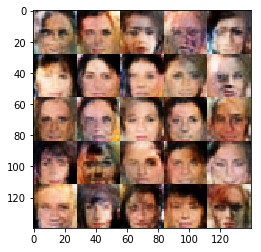

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8638


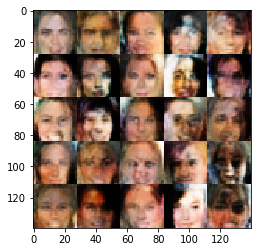

Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6651


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。